In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#required packages.
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import datetime
import itertools
import argparse
import collections

Prior to using the Earth Engine Python client library, you need to authenticate (verify your identity) and use the resultant credentials to initialize the Python client. The authentication flows use Cloud Projects to authenticate, and they're used for unpaid (free, noncommercial) use as well as paid use. To authenticate and initialize, run the following codes.

https://developers.google.com/earth-engine/guides/auth


In [4]:
import ee
# # Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='')

## utils

In [5]:
#must run these codes
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def ee_array_to_df1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

## Sentinel-1 point values

* It's better to test acsending format data as well.
* using spatial mean value instead ? https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD



In [ ]:
def get_s1_features(r_lon, r_lat, scale, i_date, f_date):
    # Define the location of interest with a point.
    poi = ee.Geometry.Point(r_lon, r_lat)

    selected_features = ['VH','VV']
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
        .filterBounds(poi)
        .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .select(selected_features)
        .filterDate(i_date, f_date)
        .mean())
    #get band values
    local_pr = s1.sample(poi, scale).first().getInfo()
    s1vh, s1vv = local_pr['properties']['VH'], local_pr['properties']['VV']

    return s1vh, s1vv

In [ ]:
i_date, f_date = '2015-01-01', '2015-12-31'
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 10
get_s1_features(r_lon, r_lat, scale, i_date, f_date)

(0.004131012130528688, 0.022650420665740967)

## Sentinel-1 time series

In [ ]:
def get_s1_time_series(r_lon, r_lat, scale, i_date, f_date, orbit_direction='ASCENDING'):
  # Define the location of interest with a point.
  poi = ee.Geometry.Point(r_lon, r_lat)

  selected_features = ['VH','VV']
  s1 = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')#
      .filterBounds(poi)
      .filter(ee.Filter.eq('orbitProperties_pass', orbit_direction))
      .filter(ee.Filter.eq('instrumentMode', 'IW'))
      .select(selected_features)
      .filterDate(i_date, f_date))

  #get the metadata of the band
  local_pr = s1.getRegion(poi, scale).getInfo()
  pr_df = ee_array_to_df(local_pr, selected_features)
  return pr_df

In [ ]:
i_date, f_date = '2015-01-01', '2015-12-31'
idx = 10
orbit_direction='ASCENDING'
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 10

s1_ts = get_s1_time_series(r_lon, r_lat, scale, i_date, f_date, orbit_direction)
s1_ts

,time,datetime,VH,VV
0,1421087672140,2015-01-12 18:34:32.140,0.016019,0.036567
1,1423161265710,2015-02-05 18:34:25.710,0.010719,0.083524
2,1424198066050,2015-02-17 18:34:26.050,0.040401,0.104398
3,1425234865940,2015-03-01 18:34:25.940,0.007824,0.053843
4,1426271666470,2015-03-13 18:34:26.470,0.011742,0.040293
5,1427308466650,2015-03-25 18:34:26.650,0.017250,0.046627
6,1428345267040,2015-04-06 18:34:27.040,0.041205,0.162769
7,1429382067630,2015-04-18 18:34:27.630,0.031764,0.110362
8,1430418868530,2015-04-30 18:34:28.530,0.019799,0.054901
9,1431455668830,2015-05-12 18:34:28.830,0.038789,0.044032


## Sentinel-1 images

### single bands

In [8]:
def get_s1_time_series_images(aoi_modis, target_band, i_date, f_date, scale, orbit_direction):
    # Load a collection
    TERRA = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')#
        .filterBounds(aoi_modis)
        .select([target_band])
        .filter(ee.Filter.eq('orbitProperties_pass', orbit_direction))
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .filterDate(i_date, f_date)
        .sort('system:time_start'))

    # Extract an image
    TERRA_list = TERRA.toList(TERRA.size())

    numpy_array = []
    for i in range(TERRA.size().getInfo()):
        Terra_img = ee.Image(TERRA_list.get(i))
        #reproject image with user defined scale
        Terra_img = Terra_img.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

        # check if image footprint contains the AOI
        image_footprint = Terra_img.geometry()
        if image_footprint.contains(aoi_modis).getInfo():
            sample = Terra_img.select(target_band).sampleRectangle(region=aoi_modis, defaultValue=0)
            numpy_array_new = np.array(sample.get(target_band).getInfo())
            numpy_array.append(numpy_array_new)
        else:
            print(f"Image {i} does not contain the AOI")
    numpy_array = np.array(numpy_array)
    return numpy_array

In [10]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
target_band = "VV"
orbit_direction='ASCENDING'
i_date, f_date = '2018-12-01', '2019-01-31'
scale = 10

s1_array = get_s1_time_series_images(aoi, target_band, i_date, f_date, scale, orbit_direction)

s1_array.shape

(14, 247, 479)

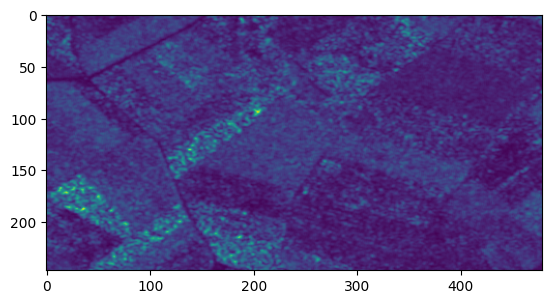

In [13]:
plt.imshow(np.nanmean(s1_array, axis=0))

### multibands

In [15]:
def convert_bands_2_numpy(s2_sr_median, aoi_vineyard, scale):
    #using the median value of multi bands
    s2_sr_mediana = s2_sr_median.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

    #collect all the available bands over the aoi
    selected_bands = ["VV","VH"]
    l8sr_bands = s2_sr_mediana.select(selected_bands).sampleRectangle(aoi_vineyard, defaultValue=0)

    band_arr = l8sr_bands.get('VV')
    s2_arr = np.array(band_arr.getInfo())

    #stack all bands together
    for idx, band in enumerate(selected_bands):
        if band == 'VV': continue
        band_arr = l8sr_bands.get(band)
        band_arr = np.array(band_arr.getInfo())
        # Stack the individual bands to make a 3-D array.
        s2_arr = np.dstack((s2_arr, band_arr))

    return s2_arr

def get_s1_multispectral_image(aoi, i_date, f_date, scale, orbit_direction):
    # Load a collection
    TERRA = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')#
        .filterBounds(aoi)
        .filter(ee.Filter.eq('orbitProperties_pass', orbit_direction))
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .filterDate(i_date, f_date)
        .mean())

    arry3d = convert_bands_2_numpy(TERRA, aoi, scale)

    return arry3d

In [17]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
target_band = "VV"
orbit_direction='ASCENDING'
i_date, f_date = '2018-12-01', '2019-01-31'
scale = 10

arry3d = get_s1_multispectral_image(aoi, i_date, f_date, scale, orbit_direction)
arry3d.shape

(247, 479, 2)

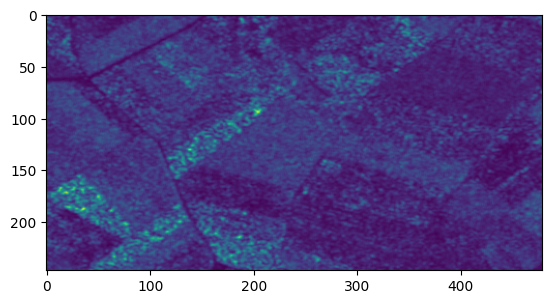

In [19]:
plt.imshow(arry3d[:,:,0])